In [1]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [4]:
from IPython.core.pylabtools import figsize

## Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

### Alternative PyMC3 Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 

\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC3, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

In [5]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

Test `25` first...

100%|██████████| 25500/25500 [00:02<00:00, 10227.35it/s]


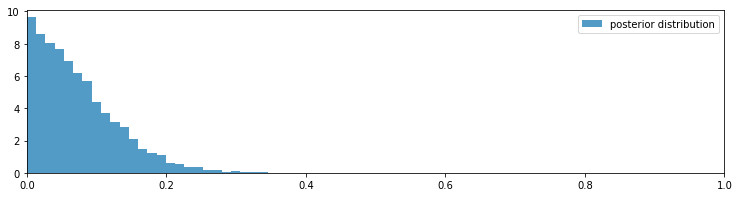

In [6]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=25)
    
with model:
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)   # much faster this time, 25k is okay
    burned_trace = trace[2500:]
    
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
#plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

Test `10`:

100%|██████████| 25500/25500 [00:02<00:00, 10479.98it/s]


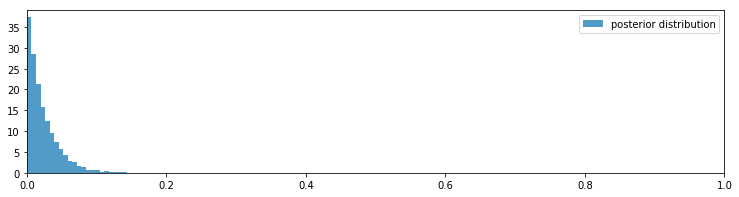

In [7]:
n_obs = 10

with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=n_obs)
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)   # much faster this time, 25k is okay
    burned_trace = trace[2500:]
    
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
#plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

Now check `50`:

100%|██████████| 25500/25500 [00:02<00:00, 10485.72it/s]


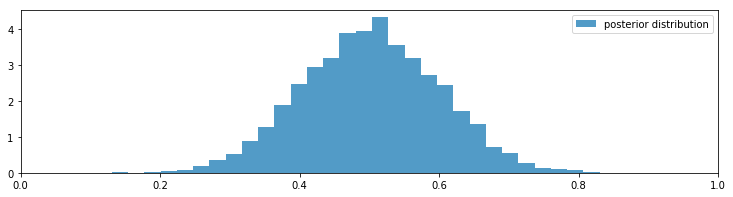

In [8]:
n_obs = 50

with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=n_obs)
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)   # much faster this time, 25k is okay
    burned_trace = trace[2500:]
    
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
#plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

## Exercises


2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

In [9]:
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


In [10]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

In [11]:
# notice the`value` here.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

Optimization terminated successfully.
         Current function value: 19.010705
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 120500/120500 [00:23<00:00, 5038.54it/s]


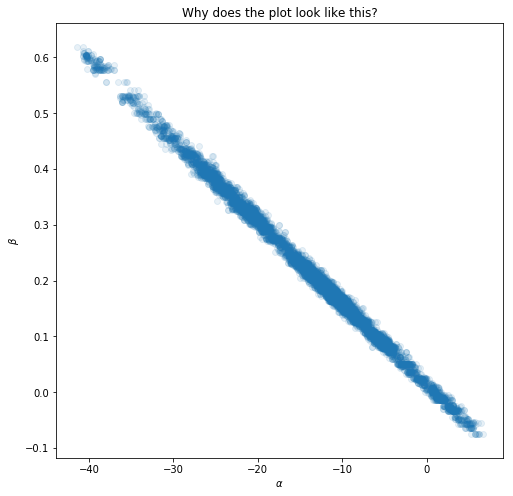

In [12]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(8, 8)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

As we shift the curve more to right (more negative alpha), the curve has to flatten out a bit (larger, more positive beta).